# NCBI Disease Corpus Candidate Labeling

Labeling disease mentions using DDlite

In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import re
import os
import sys
import bz2
import csv
import codecs
import cPickle
import itertools
import numpy as np
from operator import itemgetter
from itertools import groupby
sys.path.insert(1, os.path.join(sys.path[0], '..'))

# AJR: Hack here...
sys.path.insert(1, '/Users/aratner/repos')

from snorkel.candidates import *

import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (18,6)

### 1. Load Precomputed Candidates and Labels

In [3]:
# LEGACY Candidates 
fp = open("/Users/aratner/Dropbox/candidates/ncbi-disease.legacy.pkl","rb")
candidate_set = cPickle.load(fp)
fp = open("/Users/aratner/Dropbox/candidates/ncbi-disease.legacy.gold.npy.pkl","rb")
gold = cPickle.load(fp)

/Library/Python/2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
print gold.keys()
print list(gold["training"]).count(1), list(gold["training"]).count(-1)
print list(gold["development"]).count(1), list(gold["development"]).count(-1)
print list(gold["testing"]).count(1), list(gold["testing"]).count(-1)

['development', 'training', 'testing']
4217 3553
652 683
807 655


In [5]:
len(gold["testing"])

1462

In [6]:
len(candidate_set["testing"])

1462

In [7]:
# Set uid -> id
for c in candidate_set['training']:
    c.id = c.uid
for c in candidate_set['development']:
    c.id = c.uid
for c in candidate_set['testing']:
    c.id = c.uid

In [8]:
HOLDOUT_SET = "test"

training = candidate_set["training"]
development = candidate_set["development"]
testing = candidate_set["testing"]

# gold labels (from NCBI Disease Corpus)
training_gold_labels = gold["training"]
development_gold_labels = gold["development"]
testing_gold_labels = gold["testing"]

print len(training_gold_labels), training_gold_labels.shape
print len(development_gold_labels), development_gold_labels.shape
print len(testing_gold_labels), testing_gold_labels.shape

num_training = len(training)
num_development = len(development)
num_testing = len(testing)

if HOLDOUT_SET == "test":
    training._candidates += development._candidates
    training._candidates += testing._candidates
    gold_labels = np.concatenate((training_gold_labels, development_gold_labels, testing_gold_labels))
else:
    training._candidates += development._candidates
    gold_labels = np.concatenate((training_gold_labels, development_gold_labels))
    
candidates = training
print "Loaded {} candidates".format(len(candidates._candidates))
print "Loaded {} gold labels".format(gold_labels.shape[0])

7770 (7770,)
1335 (1335,)
1462 (1462,)
Loaded 10567 candidates
Loaded 10567 gold labels


## Load Dictionaries
Several labeling functions make use of dictionaries or curated resources like acronynms/abbreviations to full disease name mappings.

In [9]:
def load_bioportal_csv_dictionary(filename):
    '''BioPortal Ontologies
    http://bioportal.bioontology.org/'''
    reader = csv.reader(open(filename,"rU"),delimiter=',', quotechar='"')
    d = [line for line in reader]
    
    dictionary = {}
    for line in d[1:]:
        row = dict(zip(d[0],line))
        dictionary[row["Preferred Label"]] = 1
        dictionary.update({t:1 for t in row["Synonyms"].split("|")})
        
    return dictionary

def load_disease_dictionary():  
    
    dictfile = "../data/dicts/diseases/snorkel/disease-names.v2.txt"
    diseases = {line.strip().split("\t")[0]:1 for line in codecs.open(dictfile, 'rb',"utf-8").readlines()}
    diseases = {word:1 for word in diseases if not word.isupper()}
    
    # Orphanet Rare Disease Ontology
    ordo = load_bioportal_csv_dictionary("../data/dicts/diseases/ordo.csv")
    ordo = {word:1 for word in ordo if not word.isupper()}
    diseases.update(ordo)
    # Human Disease Ontology 
    doid = load_bioportal_csv_dictionary("../data/dicts/diseases/DOID.csv")
    doid = {word:1 for word in doid if not word.isupper()}
    diseases.update(doid)
    # ------------------------------------------------------------
    # remove cell dysfunction terms
    dictfile = "../data/dicts/diseases/cell_molecular_dysfunction.txt"
    terms = dict.fromkeys([line.strip().split("\t")[0] for line in open(dictfile).readlines()])
    diseases = {word:1 for word in diseases if word not in terms} 
    # remove geographic terms
    dictfile = "../data/dicts/diseases/umls_geographic_areas.txt"
    terms = dict.fromkeys([line.strip().split("\t")[0] for line in open(dictfile).readlines()])
    diseases = {word:1 for word in diseases if word not in terms}
    # ------------------------------------------------------------

    # remove stopwords
    dictfile = "../data/dicts/diseases/stopwords.txt"
    stopwords = [line.strip().split("\t")[0] for line in open(dictfile).readlines()]
    diseases = {word:1 for word in diseases if word.lower() not in stopwords}  
    
    return diseases

def load_acronym_dictionary():     
    dictfile = "../data/dicts/diseases/snorkel/disease-names.v2.txt"
    diseases = {line.strip().split("\t")[0]:1 for line in codecs.open(dictfile, 'rb', "utf-8").readlines()}
    diseases = {word:1 for word in diseases if word.isupper()}
    
    # Orphanet Rare Disease Ontology
    ordo = load_bioportal_csv_dictionary("../data/dicts/diseases/ordo.csv")
    ordo = {word:1 for word in ordo if word.isupper()}
    diseases.update(ordo)
    
    # Human Disease Ontology 
    doid = load_bioportal_csv_dictionary("../data/dicts/diseases/DOID.csv")
    doid = {word:1 for word in doid if word.isupper()}
    diseases.update(doid)
    
    # filter by char length
    diseases = {word:1 for word in diseases if len(word) > 1}
    
    return diseases


def load_molecular_dysfunction():
    dictfile = "../data/dicts/diseases/cell_molecular_dysfunction.txt"
    terms = dict.fromkeys([line.strip().split("\t")[0] for line in open(dictfile).readlines()])
    return terms


def load_chemdner_dictionary():
    dict_fnames = ["../data/dicts/chemicals/mention_chemical.txt",
                   "../data/dicts/chemicals/chebi.txt",
                   "../data/dicts/chemicals/addition.txt",
                   "../data/dicts/chemicals/train.chemdner.vocab.txt"]
    chemicals = []
    for fname in dict_fnames:
        chemicals += [line.strip().split("\t")[0] for line in codecs.open(fname,"rU","utf-8").readlines()]

    # load bzip files
    fname = "../data/dicts/chemicals/substance-sab-all.bz2"
    chemicals += {line.strip().split("\t")[0]:1 for line in bz2.BZ2File(fname, 'rb').readlines()}.keys()
        
    # remove stopwords
    fname = "../data/dicts/chemicals/stopwords.txt"
    stopwords = {line.strip().split("\t")[0]:1 for line in open(fname,"rU").readlines()}
    chemicals = {term:1 for term in chemicals if term not in stopwords}
    return chemicals
    

def load_specialist_abbreviations():
    '''Load UMLS SPECIALIST Lexicon of abbreviations. Format:
        E0000048|AA|acronym|E0006859|achievement age|
    '''
    fpath = "../data/dicts/diseases/SPECIALIST.bz2"
    d = [line.strip().strip("|").split("|") for line in bz2.BZ2File(fpath, 'rb').readlines()]
    abbrv2text,text2abbrv =  {},{}
    for row in d:
        uid1,abbrv,atype,uid2,text = row
        text = text.lower()
        if atype not in ["acronym","abbreviation"]:
            continue
        if abbrv not in abbrv2text:
            abbrv2text[abbrv] = {}
        if text not in text2abbrv:
            text2abbrv[text] = {}
            
        abbrv2text[abbrv][text] = 1
        text2abbrv[text][abbrv] = 1
    
    return abbrv2text,text2abbrv


def load_umls_dictionary():
    umls_dict = {}
    dict_fnames = ["../data/dicts/diseases/umls/snomedct.disease_or_syndrome.txt",
                   "../data/dicts/diseases/umls/snomedct.sign_or_symptom.txt",
                   "../data/dicts/diseases/umls/snomedct.finding.txt",
                   "../data/dicts/diseases/umls/mesh.disease_or_syndrome.txt",
                   "../data/dicts/diseases/umls/mesh.sign_or_symptom.txt"]
    
    for fname in dict_fnames:
        sab,sty = fname.split("/")[-1].split(".")[:2]
        if sab not in umls_dict:
            umls_dict[sab] = {}
        if sty not in umls_dict[sab]:
            umls_dict[sab][sty] = {}
        umls_dict[sab][sty] = {line.strip().split("\t")[0]:1 for line in codecs.open(fname, 'rU',"utf-8").readlines()}
        
    return umls_dict
    

In [10]:
diseases = load_disease_dictionary()
diseases.update(load_acronym_dictionary())

dysfunction = load_molecular_dysfunction()
syndromes = {t.strip().lower():1 for t in codecs.open("../data/dicts/diseases/syndromes.txt","rU",'utf-8').readlines()}
proteins_enzymes_genes = {t.strip().lower():1 for t in codecs.open("../data/dicts/diseases/all.proteins_enzymes.txt","rU",'utf-8').readlines()}

In [11]:
umls_dict = load_umls_dictionary()
chemicals = load_chemdner_dictionary()

ordo = load_bioportal_csv_dictionary("../data/dicts/diseases/ordo.csv")
doid = load_bioportal_csv_dictionary("../data/dicts/diseases/DOID.csv")
    
abbrv2text, text2abbrv = load_specialist_abbreviations()

## Document & Sentence Candidate Views

Some feature labeling functions benefit from more global views of the candidate set, such as at the document or sentence level. 

In [12]:
# Sentence/Document-level candidate index
candidx = {}
for c in candidates:
    if c.doc_id not in candidx:
        candidx[c.doc_id] = {}
    if c.sent_id not in candidx[c.doc_id]:
        candidx[c.doc_id][c.sent_id] = {}
    for i in c.idxs:
        candidx[c.doc_id][c.sent_id][i] = candidx[c.doc_id][c.sent_id].get(i,[]) + [c]

# Candidate document frequency. The more often a candidate appears in a
# single document, the more likely it's a real mention
cand_df = {}
for doc_id in candidx.keys():
    cand_df[doc_id] = {}
    for sent_id in candidx[doc_id]:
        for i in sorted(candidx[doc_id][sent_id]):
            offset_cands = candidx[doc_id][sent_id][i]
            text = [" ".join([c.words[idx] for idx in c.idxs]) for c in offset_cands]
            for t in text:
                cand_df[doc_id][t] = cand_df[doc_id].get(t,0) + 1

In [13]:
# Helper functions
TRUE,FALSE,ABSTAIN = 1,-1,0

def left_window(m, window=3, match_attrib="lemmas"):
    idx = max(0,min(m.idxs) - window)
    span = range(idx,min(m.idxs))
    return [m.__getattr__(match_attrib)[i] for i in span]

def right_window(m, window=3, match_attrib="lemmas"):
    idx = min(len(m.words), max(m.idxs) + window + 1)
    span = range(max(m.idxs) + 1,idx)
    return [m.__getattr__(match_attrib)[i] for i in span]

def contains(m, word):
    return word in [m.lemmas[i] for i in m.idxs]

def get_sentence_candidates(m):
    '''Return all candidates in the same sentence as m'''
    neighbors = [candidx[m.doc_id][m.sent_id][i] for i in candidx[m.doc_id][m.sent_id]]     
    neighbors = set(itertools.chain.from_iterable(neighbors))
    return sorted(neighbors,key=lambda x:min(x.idxs),reverse=0)

def get_document_candidates(m):
    '''Return all candidates in the same sentence as m'''
    neighbors = []
    for sent_id in candidx[m.doc_id]:
        neighbors += [candidx[m.doc_id][sent_id][i] for i in candidx[m.doc_id][sent_id]]     
    return set(itertools.chain.from_iterable(neighbors))

In [14]:
context_kw = set(['high-grade', 'progression', 'incidence', 'prevalence', 'diagnosis'])

# training set stopwords / false positives
vague = ['aggressive','immunosuppression','abnormality', 'absence', 'activity', 'adult', 
         'adult-onset', 'age of onset', 'all age', 
         'animal model', 'ashkenazi jewish', 'asymptomatic', 'atypical', 'black', 
         'blood', 'blue', 'brazilian', 'carrier', 'case', 'cause by a', 'center', 'child', 
         'close', 'combination', 'common', 'completely', 'condition', 'contraction', 'correlation', 
         'critical', 'damage', 'death', 'defect', 'deficiency', 'detect', 'diagnose', 
         'diagnosis', 'disease', 'disease model', 'disorder', 'distortion', 'does', 'donor', 
         'early onset', 'early-onset', 'employ', 'ethnic', 'false negative', 'false positive', 
         'family', 'family history', 'family study', 'fatal', 'founder', 'germline', 'grade', 
         'greater than', 'heterozygous', 'high risk', 'high-grade', 'history', 'homozygous', 
         'human model', 'identify', 'incidence', 'independent', 'indicate', 'individual', 
         'infection', 'inheritance', 'instability', 'intermediate', 'late-onset', 'lesion', 
         'less than', 'lethal', 'location', 'long arm', 'low risk', 'mass', 'max', 
         'missense', 'mobility', 'model', 'moderate', 'moderate risk', 'mouse model', 'negative', 
         'newborn', 'novel', 'one family', 'outcome', 'parameter', 'pathogenesis', 'patient die', 
         'physical', 'platelet', 'positive', 'prevalence', 'progression', 'proliferation', 
         'protection', 'radiation', 'rank', 'reading', 'red', 'reduce', 'reflex', 'remission', 
         'response', 'responsible', 'result', 'same family', 'sensitivity', 'sex', 'single', 
         'sit', 'skip', 'southern blot', 'staining', 'strain', 'study', 'suffering', 
         'suppression', 'syndrome', 'test', 'therapy', 'transmission', 'transplant', 
         'unrelated', 'unstable', 'usually fatal', 'very close', 'very high', 'very large', 
         'very rare', 'vibration', 'white', 'withdrawal', 'zeta', 'atm']

vague += ['most case','examine for','increase activity','european origin','clinical sign']
vague += ['colorectal']
vague += ["alpha", "beta", "gamma"]
vague += ["type i", "type ii", "type iii", "class i", "class ii", "class iii", "stage i", "stage ii", "stage iii"]
vague += ['rflp', 'ashkenazi jewish', 'dmt1', 'c2', 'sscp', 'pcr', 'mefv', 'phenylalanine hydroxylase', 'fas',
          'g6pd', 'autosomal dominant', 'wt1', 'vlcad', 'missense', 'plp', 'wasp', 'does not', 'fmrp', 'ph',
          'gaa', 'dtdst', 'galt', 'hgo', 'pah', 'nervous system', 'normal', 'an2', 'arsa', 'aga', 'mentally alert',
          'absent', 'galc', 'lpp', 'cga', 'esr', 'cm', 'rr', 'dn', 'gt']

vague = set(vague)

organs = set(["brain","heart","lung","muscle","tissue","stomach",'skin','spinal cord'])

# "gene" and "chromosome" tend to refer to disease sites
gene_terms = set(["encodes","amino", "acid", "protein", "cells", "sequencing", "dna"])

intensity_terms = set(["acute","progressive","recurrent","mild","severe",
                       "extreme","low","normal","premature","classic"])

modifier_terms = ['adult-onset','early-onset','juvenile-onset','childhood-onset']

# The most frequent error is a partial span match, e.g., 
# "VLCAD deficiency" is the correct label but our candidate is "VLCAD"
# These are the most common dropped prefix/suffixes in the NCBI training data
left_terms = set(['maternal', 'adolescent', 'neonatal', 'adult', 'childhood',
                  'familial',"hereditary","autosomal", "autoimmune","inherited"])

right_terms = set(['deficienty', 'syndrome', 'disorders', 'deficient', 'defects', 'tumors', 
                   'disease', 'tumor', 'deficiency', 'deficiencies', 'dysfunction', 'infection'])

indicators = set(['cancer', 'cancers', 'tumor', 'tumors', 'tumour', 'tumours', 'dm'])

bodypart = ["abdomen", "adam's apple", "adenoids", "adrenal gland", "anatomy", "ankle", "anus",
            "appendix", "arch", "arm", "artery", "back", "ball of the foot", "belly", "belly button",
            "big toe", "bladder", "blood", "blood vessels", "body", "bone", "brain", "breast", "buttocks",
            "calf", "capillary", "carpal", "cartilage", "cell", "cervical vertebrae", "cheek", "chest",
            "chin", "circulatory system", "clavicle", "coccyx", "collar bone", "diaphragm", "digestive system",
            "ear", "ear lobe", "elbow", "endocrine system", "esophagus", "eye", "eyebrow", "eyelashes",
            "eyelid", "face", "fallopian tubes", "feet", "femur", "fibula", "filling", "finger",
            "fingernail", "follicle", "foot", "forehead", "gallbladder", "glands", "groin", "gums",
            "hair", "hand", "head", "heart", "heel", "hip", "humerus", "immune system", "instep",
            "index finger", "intestines", "iris", "jaw", "kidney", "knee", "larynx", "leg", "ligament",
            "lip", "liver", "lobe", "lumbar vertebrae", "lungs", "lymph node", "mandible", "metacarpal",
            "metatarsal", "molar", "mouth", "muscle", "nail", "navel", "neck", "nerves", "nipple", "nose",
            "nostril", "organs", "ovary", "palm", "pancreas", "sperm" ,"patella", "pelvis", "phalanges", "pharynx",
            "pinky", "pituitary", "pore", "pupil", "radius", "rectum", "red blood cells", "respiratory system",
            "ribs", "sacrum", "scalp", "scapula", "senses", "shin", "shoulder", "shoulder blade", "skeleton",
            "skin", "skull", "sole", "spinal column", "spinal cord", "spine", "spleen", "sternum", "stomach",
            "tarsal", "teeth", "tendon", "testes", "thigh", "thorax", "throat", "thumb", "thyroid", "tibia",
            "tissue", "toe", "toenail", "tongue", "tonsils", "tooth", "torso", "trachea", "ulna", "ureter",
            "urethra", "urinary system", "uterus", "uvula", "vein", "vertebra", "waist", "white blood cells", "wrist"]

symptom = (["bleeding", "ph", "symptoms","symptom", "adhesion", "disequilibrium", "hemolytic"])

bodysym = bodypart + symptom

common_disease = ["alkaptonuria", "alps", "analbuminemia", "aniridia", "ankylosing spondylitis", "argininemia",
                  "aspartylglucosaminuria", "breast-ovarian cancer", "c5-deficient",
                  "cataracts", "cerebral ald", "choroideremia", "chrpe", "cleft palate", "cnsha",
                  "dfnb4", "hemri", "hepatoblastoma", "hypopigmentation",
                  "lesch-nyhan", "lip pits", "malaria", "melanoma", "mental retardation", "mps iva", "myotonia",
                  "nbs", "obesity", "phenylketonuria", "piebaldism", "renal failure", "retinal degeneration",
                  "short stature", "thrombocytopenia", "nephropathy", "adenomas", 
                  "attenuated adenomatous polyposis coli", "fragile x", "cataract", "fever", "leukemia", 
                  "retinoblastoma", "pws"]

common_disease += ["periodontitis", "favism", "sudden death", "psoriasis", "cardiac involvement", "peroxisomal disorder", 
                   "adrenal insufficiency", "systemic lupus erythematosus", "g6pd-deficient", "c2-deficient", 
                   "acg1b", "diabetes mellitus", "insulin-dependent diabetes mellitus", "myotonia levior",
                   "meningococcal infection", "g6pd deficient", "hydrocephalus", "dystonia", "adndi", "cerebellar degeneration", 
                   "mucopolysaccharidosis iva", "myopathy", "embryonic lethality", "anhaptoglobinemia", "non-syndromic hearing loss", 
                   "mentally retarded", "chondrodysplasia", "genetic disorder", "growth retardation", "abnormal color vision", 
                   "hypotonia", "hyperphenylalaninemia", "ovarian cancers", "lysosomal storage disorder", "dopa-responsive dystonia"]

common_disease += ["pah-deficient", "genetic disease", "cleft lip", "homozygous hypobetalipoproteinemia", "deficiency of c5",
                   "white matter lesions", "immunodeficiency", "hemangioblastomas", "tay-sachs", "arthralgias", 
                   "paroxysmal nocturnal hemoglobinuria", "brca1 abnormalities", "thyroid goiter", "enzymopathy", 
                   "hypersensitivity to ionizing radiation", "idiopathic ventricular fibrillation", "hypomyelination", "eczema", 
                   "infertility", "pseudohermaphroditism", "pros1 gene defect", "muscle wasting", "adca type i", 
                   "classic galactosemia", "diabetes insipidus", "anterior segment malformations", "c6-deficient", 
                   "hemophilia", "bladder symptoms", "gm1-gangliosidosis"]

common_disease += ["blindness", "depression", "diabetes", "early death", "genetic defects", 
                   "genetic lesions", "leukemias", "obese", "piebald", "pneumonia", "recessive disorders", 
                   "sudden cardiac death", "visual loss"]

non_common_disease = []

common_disease_acronyms = ["AAPC", "AAS", "ABCD syndrome", "ACC", "ACS", "ACTH deficiency", "AD", "AD", "ADD",
                           "ADD-RT", "ADEM", "ADHD", "AF", "AGS", "AHC", "AIDS", "AIP", "ALA DD", "ALI", "ALS",
                           "AMD", "AOS", "APA", "APS", "ARBD", "ARD", "ARDS", "Acute respiratory distress syndrome",
                           "ARND", "AS", "ASD", "ASDs", "A-T", "AVMs", "B-NHL", "BBS", "BEB", "BD", "BEH", "BFIC", "BH", "BMD", "BPD",
                           "BPH", "BS", "BSE", "BSS", "BV", "CACH", "CAD", "CADSIL", "CAPD", "CCD", "CCHF", "CCHS",
                           "CCM", "CDG", "CDGS", "CEP", "CES", "CESD", "CF", "CFIDS", "CFS", "CGBD", "CHD", "CHF", "CHS"
                           "CIDP", "CIPA", "CJD", "CLD", "COFS", "COPD", "CP", "CP/CPPS", "CPDD", "CPM", "CPPS", "CRF",
                           "CRKP", "CRPS", "CSA", "CSD", "CVD", "DAS", "DBA", "DBMD", "DD", "DEF", "DF", "DH",
                           "DHF", "DiG", "DLB", "DM", "DMD", "DP", "DRSP disease", "DS", "DSPS", "DTs", "DVD",
                           "DVT", "ED", "EDS", "EEE", "EHK", "EMH", "EMR", "ENS", "EPM", "EPP", "ESRD", "ESS", "EVA"
                           "FAE", "FASDs", "FFI", "FMA", "FMD", "FMF", "FMS", "FNDI", "FSP", "FTD", "FVS", "FXS", 
                           "GAD", "GAN", "GAS disease", "GBS", "GBS disease", "GCE", "GERD", "GI", "GIB", "GN",
                           "GRMD", "GSS disease", "GT/LD", "GVHD", "GWD", "HAS", "HBL", "HCP", "HD", "HDL2", "HEELP syndrome",
                           "HFA", "HFMD", "HFRS", "HI", "HiB disease", "HMSN Type III", "HMS", "HOH", "HTN",
                           "HPRT deficiency", "HPS", "HPV Infection", "HSP", "IBD", "IBIDS syndrome", "IBM",
                           "IBS", "IBS", "IC/PBS", "ICF syndrome", "IDMS", "IHA", "IED", "IFAP syndrome", "INAD", "IP",
                           "IRD", "IS", "ITP", "JAS", "JE", "JHD", "JRA", "JT", "KS", "KSS", "KTW Syndrome",
                           "LCM", "LEMS", "LFA", "LGV", "LKS", "LNS", "LP", "MAC", "MBD", "MCS", "MD",
                           "MDD", "MDR TB", "MEF", "MHP", "MID", "MJD", "ML", "MLD", "MMA", "MMR", "MMRV", "MND", "MOH", "MPD",
                           "MPS I", "MPS II", "MPS III", "MPS IV", "MPS VI", "MPS VII", "MR/DD", "MS", "MSA",
                           "MSDD", "NAS", "NBIA", "NCL", "NF1", "NF2", "NKH", "NLD", "NMDs", "NMO", "NMS", "NP",
                           "NPC1", "NPH", "NTD", "NTDs", "OA", "OCD", "ODD", "OMA", "ON", "OPC", "OPCA", "OSA",
                           "PBC", "PBD", "PCOS", "PCT", "PDD", "PDD-NOS", "PDD/NOS", "PKAN", "PLMD", "PLS",
                           "PMD", "PML", "PMS", "POTS", "PPMA", "PPS", "PSC", "PSP", "PVL", "PW", "Q fever", "RA",
                           "RAD", "RIND", "RLF", "RLS", "RMDs", "ROP", "RS", "RSD", "RTI", "SARS", "SB", "SBS", "SC",
                           "SIDS", "SIS", "SLE", "SM", "SMA", "SMEI", "SMS", "SOD", "SPS", "SSPE", "STEMI",
                           "STD", "SUNCT", "SWS", "TAC", "TB", "TBI", "TCD", "TCS", "TEF", "TIA", "TMH", "TMJ/TMD", "TMR",
                           "TN", "TOS", "TS", "TS", "TSC", "TSEs", "TSP", "TTH", "TTP", "UCPPS", "UDA", "UTIs", "UC",
                           "URI", "VCFS", "vCJD", "VD", "VHF", "VP", "VSD", "VVC", "VWM disease",
                           "WAGR syndrome", "WD", "WEE", "WFS", "WS", "XLT", "XDR TB", "XLDCM", "XLSA", "XP", "YSS", "YVS", 
                           "ZBLS", "SCA1", "SCA2", "C1D", "C3D", "C4D", "C5D", "C6D", "C7D", "CCALD", "CL/P",
                           "SJS type 2"]

non_disease_acronyms = ["GALT", "PAH", "SSCP", "MEFV", "DTDST", "WASP", "VLCAD", "HGO", "MCC", "CT", "TGA", "AVP", "TGA", "ARSA",
                        "IDDM4", "AGA", "TfR", "CI", "PTT", "IC", "ACTH", "IVA", "FH", "GALC"]

ban_words = ["unrelated", "negative", "does not", "responsible", "result", "novel", "test", "positive", "instability",
             "normal", "detected", "case", "prevalence", "heterozygous", "germline", "family", "blood", "skin",
             "defect", "common", "activity", "individual", "close", "homozygous", "disorder", "identified"
             "missense", "carrier", "diagnosis", "lactating"]



# ---------------------------------------------------------
# 1: Document-level 
# ---------------------------------------------------------

# These labeling functions require global knowledge (e.g., document frequencies) 
# or access to all candidates in a given document

def LF_candidate_df(m):
    '''Candidates that only appear once in the document are usually incorrect'''
    text = " ".join(m.mention())
    return FALSE if text in cand_df[m.doc_id] and cand_df[m.doc_id][text] == 1 else ABSTAIN

def LF_known_abbreviation(m):
    '''Use the SPECIALIST lexicon to disambiguate known acronyms/abbreviations'''
    doc_candidates = get_document_candidates(m)
    phrase = " ".join(m.mention())
    mentions = set([" ".join(c.mention()).lower() for c in doc_candidates if c != m])
    # if a disease name and its abbreviation appear in a document, both are likely true     
    if phrase in abbrv2text and set(abbrv2text[phrase].keys()).intersection(mentions):
        return TRUE
    elif phrase in text2abbrv and set(text2abbrv[phrase].keys()).intersection(mentions):
        return TRUE
    return ABSTAIN

def LF_undefined_abbreviation(m):
    '''Candidate is a known abbreviation, but no corresponding full name in document'''
    doc_candidates = get_document_candidates(m)
    phrase = " ".join(m.mention())
    mentions = set([" ".join(c.mention()).lower() for c in doc_candidates if c != m])
    if len(phrase) > 1 and phrase in abbrv2text and not set(abbrv2text[phrase].keys()).intersection(mentions):
        return FALSE
    return ABSTAIN
    
def LF_in_title(m): 
    doc_candidates = get_document_candidates(m)
    mention = " ".join(m.mention()).lower()
    for c in doc_candidates:
        if (c.sent_id==m.sent_id and c.idxs==m.idxs) or c.sent_id==m.sent_id:
            continue
        if (c.sent_id == 0 or m.sent_id == 0) and mention == " ".join(c.mention()).lower():
            if len(m.mention()) > 1:
                return TRUE
            
    return ABSTAIN
    
# ---------------------------------------------------------
# 2: Sentence-level
# ---------------------------------------------------------

def LF_in_list(m):
    '''Multiple candidates seperated by [,;]+ are probably in a list of mentions'''
    neighbors = get_sentence_candidates(m)
    sidx = m.idxs[-1]
    for i in range(0,len(neighbors)):
        eidx = neighbors[i].idxs[0]
        if eidx - sidx <= 0:
            continue
        if eidx - sidx == 2 and re.search("[;,]+",m.words[sidx+1]):
            return TRUE
    
    return ABSTAIN

def LF_contiguous_mentions(m):
    '''CANDIDATE FIX labeling function contiguous candidates are likely wrong'''
    neighbors = get_sentence_candidates(m)
    sidx = m.idxs[-1]
    for i in range(0,len(neighbors)):
        eidx = neighbors[i].idxs[0]
        if eidx - sidx == 1:
            return FALSE
    
    return ABSTAIN

# ---------------------------------------------------------
# 3: Mention-level
# ---------------------------------------------------------

# ======================
# TRUE
# ======================

def LF_dropped_syndrome(m):
    '''name <SYNDROME> where sydrome is dropped and implied'''
    phrase = " ".join(m.mention()).lower()
    return TRUE if phrase in syndromes else ABSTAIN

def LF_tumors_growths(m):
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if re.search("^(\w* ){0,2}(['] )*(tumor|tumour|polyp|pilomatricoma|cyst|lipoma)$",phrase) else ABSTAIN
    
def LF_dep_path(m):
    keywords = set(["cause","prevent","treat"])
    #return TRUE if 'cause' in [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs] else ABSTAIN
    path = [m.lemmas[m.dep_parents[i] - 1] for i in m.idxs]
    return TRUE if keywords.intersection(path) else ABSTAIN

def LF_acronym_def(m):
    '''Becker muscular dystrophy (BMD)'''
    window = right_window(m,window=4,match_attrib="words")
    is_def = window[0] == "-LRB-" and '-RRB-' in window if window else 0
    
    if is_def:
        j = window.index('-RRB-')
        acronym = "".join(window[1:j])
        is_def = is_def and acronym.isupper() and acronym in abbrv2text
        
    return TRUE if is_def else ABSTAIN

def LF_long_phrase(m):
    '''Longer dictionary matches correlate with higher confidence in matches'''
    return TRUE if len(list(m.idxs)) > 4 else ABSTAIN

def LF_keyword_context_match(m):
    '''Some highly correlated context words'''
    w = 2
    window = set(left_window(m,window=w) + right_window(m,window=w))
    return TRUE if context_kw.intersection(window) else ABSTAIN

def LF_cancer(m):
    '''<TYPE> cancer'''
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if re.search("\w* cancer",phrase) else ABSTAIN

def LF_disease_syndrome(m):
    '''<TYPE> disease or <TYPE> syndrome'''
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if re.search("\w* (disease|syndrome)+",phrase) else ABSTAIN

def LF_deficiency(m):
    '''<TYPE> deficiency'''
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if re.search("\w* deficiency",phrase) else ABSTAIN

def LF_deficiency_of(m):
    '''deficiency of <TYPE>'''
    phrase = " ".join(m.mention()).lower()
    return TRUE if phrase.endswith('deficiency') or phrase.startswith('deficiency') or phrase.endswith('dysfunction') else ABSTAIN

def LF_come_with(m):
    phrase = ' '.join(m.mention())
    w = ' '.join(right_window(m,window=1))
    return TRUE if phrase in ["APC", "PDS"] and w in ['gene', 'mutations', 'mutation'] else ABSTAIN

def LF_contain_disease(m):
    phrase = ' '.join(m.mention()).lower()
    return TRUE if phrase.endswith(' disease') and 'von' not in phrase and len(intensity_terms.intersection([m.lemmas[i] for i in m.idxs]))==0 else ABSTAIN

def LF_indicators(m):
    '''Indicator words'''
    return TRUE if " ".join(m.mention()).lower() in indicators else ABSTAIN

def LF_common_disease(m):
    '''Common disease'''
    return TRUE if " ".join(m.mention()).lower() in common_disease else ABSTAIN

def LF_common_disease_acronyms(m):
    '''Common disease acronyms'''
    return TRUE if " ".join(m.mention()) in common_disease_acronyms else ABSTAIN

def LF_noun_phrases(m):
    '''Noun phrase of form JJ|FW|NN[P]* and at least 2 tokens'''
    pos_tags = [m.poses[i] for i in m.idxs]
    tags = " ".join(pos_tags)
    return TRUE if re.search("^(JJ\s){1,}(NN[PS]*\s*){1,}$",tags) else ABSTAIN
    
def LF_all_uppercase(m):
    '''Acronyms without digits are often disease abbreviations'''
    phrase = " ".join([m.words[i] for i in m.idxs])
    if len(phrase) > 3:
        return ABSTAIN
    return TRUE if phrase.isupper() and not re.search("\d+",phrase) else ABSTAIN

def LF_parentheses(m):
    '''Parentheses around mention'''
    lw = " ".join(left_window(m,window=1)).lower()
    rw = " ".join(right_window(m,window=1)).lower()
    phrase = " ".join(m.mention()).lower()
    return TRUE if lw in ["-lrb-", "("] and rw in ["-rrb-", ")"] else ABSTAIN

def LF_type_x(m):
    '''Type I <DISEASE>'''
    phrase = " ".join(m.mention())
    return TRUE if re.search("(\w\s)*([Tt]ype|[Cc]lass|[Ff]actor) [GD]*\s*[IVab]+",phrase) else ABSTAIN

def LF_population(m):
    context = left_window(m,window=3) + right_window(m,window=3)
    return TRUE if population.intersection(context) else ABSTAIN

def LF_right_negative_argument(m):    
    #phrase = " ".join(m.mention()).lower()
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    pattern = "^(history of|mitochondrial|amino acid)( \w+){1,2}"
    return FALSE if re.search(pattern,phrase) else ABSTAIN

def LF_right_positive_argument(m):    
    #phrase = " ".join(m.mention()).lower()
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    pattern = "^(\w+\-onset|x\-linked|maternal|adult|neonatal|childhood|adolescent|autosomal|congenital|chronic|familial|deficiency|abnormal|abnormality|hereditary)( \w+){1,2}"
    return TRUE if re.search(pattern,phrase) else ABSTAIN

def LF_left_positive_argument(m):    
    #phrase = " ".join(m.mention()).lower()
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    pattern = "(\w+ ){1,2}(infection|lesion|neoplasm|attack|defect|anomaly|abnormality|degeneration|carcinoma|lymphoma|tumor|tumour|deficiency|malignancy|hypoplasia|disorder|deafness|weakness|condition|dysfunction|dystrophy)$"
    return TRUE if re.search(pattern,phrase) else ABSTAIN

def LF_left_negative_argument(m):    
    #phrase = " ".join(m.mention()).lower()
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    pattern = "(\w+ ){1,2}(variability|result|counseling|phenotype|correlation|transmission|form|status|level|finding|dominant|recessive|analysis|mutation|mass|block|complication|interaction|gene|diagnosis|patient|saturation|frequency|response|carrier|locus|heterogeneity|outcome|symptom|inheritance)$"
    return FALSE if re.search(pattern,phrase) else ABSTAIN

def LF_medical_afixes(m):
    # TODO Get all from https://en.wikipedia.org/wiki/List_of_medical_roots,_suffixes_and_prefixes#Prefixes_and_suffixes
    pattern = "(\w+(pathy|stasis|trophy|plasia|itis|osis|oma|asis|asia)$|^(hyper|hypo)\w+)"
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    return TRUE if re.search(pattern,phrase) else ABSTAIN
    

#
# Dictionary labeling functions
#
def LF_DOID_human_disease_ontology(m):
    '''Mention is in the Human Disease Ontology'''
    phrase = " ".join(m.mention())
    return TRUE if phrase in doid else ABSTAIN

def LF_cell_molecular_dysfunction(m):
    phrase = " ".join(m.mention())
    return TRUE if phrase in dysfunction else ABSTAIN

def LF_SNOWMED_CT_sign_or_symptom(m):
    phrase = " ".join(m.mention())
    return TRUE if phrase in umls_dict["snomedct"]["sign_or_symptom"] else ABSTAIN

def LF_SNOWMED_CT_disease_or_syndrome(m):
    phrase = " ".join(m.mention())
    return TRUE if phrase in umls_dict["snomedct"]["disease_or_syndrome"] else ABSTAIN

def LF_MESH_disease_or_syndrome(m):
    phrase = " ".join(m.mention())
    return TRUE if phrase in umls_dict["mesh"]["disease_or_syndrome"] else ABSTAIN

def LF_MESH_sign_or_symptom(m):
    phrase = " ".join(m.mention())
    return TRUE if phrase in umls_dict["mesh"]["sign_or_symptom"] else ABSTAIN

# ======================
# FALSE
# ======================

def LF_dangling_phrase(m):
    pos_tags = " ".join([m.poses[i] for i in m.idxs])
    return FALSE if re.search("NN[PS]* (JJ|IN|DT)$",pos_tags) else ABSTAIN
    
def LF_family(m):
    return FALSE if "family" in " ".join(m.mention()) else ABSTAIN

def LF_has_punctuation(m):
    return FALSE if re.search("[=%]+"," ".join(m.mention())) else ABSTAIN

def LF_organs(m):
    phrase = " ".join(m.mention()).lower()
    return FALSE if phrase in organs else ABSTAIN   

def LF_bodysym(m):
    phrase = " ".join(m.mention()).lower()
    return FALSE if phrase in bodysym else ABSTAIN       

def LF_chemical_name(m):
    phrase = " ".join(m.mention())
    return FALSE if phrase in chemicals and not phrase.isupper() else ABSTAIN

def LF_protein_chemical_abbrv(m):
    '''Gene/protein/chemical name'''
    lemma = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if re.search("\d+",lemma) else ABSTAIN

def LF_gene_abbrv(m):
    '''Gene/protein/chemical name'''
    lemma = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if re.search("\d+",lemma) and lemma.isupper() else ABSTAIN

def LF_base_pair_seq(m): 
    lemma = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if re.search("^[GACT]{2,}$",lemma) else ABSTAIN

def LF_too_vague(m):
    phrase = " ".join([m.lemmas[i] for i in m.idxs]).lower()
    phrase_ = " ".join(m.mention()).lower()
    return FALSE if phrase in vague or phrase_ in vague else ABSTAIN

def LF_ban_words(m):
    phrase = ' '.join(m.mention()).lower().split()
    return FALSE if set(phrase).intersection(ban_words) else ABSTAIN

def LF_activity(m):
    phrase = " ".join(m.mention()).lower()
    return FALSE if phrase.endswith('activity') else ABSTAIN

def LF_negation(m):
    neg = set(["not","no"])
    return FALSE if neg.intersection([m.lemmas[i] for i in m.idxs]) else ABSTAIN

def LF_weakness(m):
    '''<TYPE> weakness'''
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return TRUE if re.search("\w* weakness",phrase) else ABSTAIN

def LF_neg_prefix(m):
    terms = ['on', 'this', 'i', 'was', 'were', 'are', 'been', 'is', 'dna', 'we', 'less'
             'peripheral', 'mutations', 'mutation', 'not', 'enzyme', 'gene', 'at', 'prenatal', 'cell']
    lw = left_window(m,window=1)
    if len(lw) > 0 and lw[0].lower() in terms:
        return FALSE
    return ABSTAIN

def LF_neg_surfix(m):
    terms = ['deficiency', 'the', 'the', 'of', 'to', 'a']
    rw = right_window(m,window=1)
    if len(rw) > 0 and rw[0].lower() in terms:
        return FALSE
    return ABSTAIN

def LF_non_common_disease(m):
    '''Non common disease'''
    return FALSE if " ".join(m.mention()).lower() in non_common_disease else ABSTAIN

def LF_non_disease_acronyms(m):
    '''Non common disease acronyms'''
    return FALSE if " ".join(m.mention()) in non_disease_acronyms else ABSTAIN

def LF_intensity_modifier(m):
    '''Do not include intensity modifiers (e.g., "severe <DISEASE NAME>")'''
    return FALSE if intensity_terms.intersection([m.lemmas[i] for i in m.idxs]) else ABSTAIN

def LF_pos_in(m):
    '''Candidates beginning with a preposition or subordinating conjunction'''
    poses = [m.poses[i] for i in m.idxs]
    return FALSE if "IN" in poses[0:1] else ABSTAIN

def LF_genetics_terminology(m):
    terms = set(["polymerase chain reaction",'PCR','pcr'])
    phrase = " ".join([m.lemmas[i] for i in m.idxs])
    return FALSE if phrase in terms else ABSTAIN

def LF_gene_chromosome_link(m):
    '''Mentions of the form "Huntington Disease gene"'''
    w = 10
    genetics_terms = set(["gene","chromosome"])
    diseases_terms = set(["disease","syndrome","disorder"])
    context = left_window(m,window=w) + right_window(m,window=w)
    # 1: contains a disease keyword or 2: in disease dictionaries
    is_disease = diseases_terms.intersection(map(lambda x:x.lower(),m.mention()))
    is_disease = is_disease or " ".join(m.mention()) in diseases
    is_gene = genetics_terms.intersection(context)    
    return FALSE if is_gene and not is_disease else ABSTAIN 

def LF_not_disease(m):
    word = ["no", "not", "do", "-lrb-", "-rrb-", "(", ")", "big", "small", "long", "short",
            "change", "store", "diagnosis", "time", "difference", "model", "dot", "dots", 
            "hp", "minor", "fas", "day", "loss", "absence", "none"]
    return FALSE if m.lemmas[min(m.idxs)].lower() in word or m.lemmas[max(m.idxs)].lower() in word or m.lemmas[max(m.idxs)].lower().endswith("ion") or m.lemmas[max(m.idxs)].lower().endswith("ive") else ABSTAIN

# probable incomplete mentions
def LF_left_window_incomplete(m):
    '''CANDIDATE FIX labeling function'''
    context = m.mention() #left_window(m,window=1)
    return TRUE if left_terms.intersection(context) else ABSTAIN

def LF_right_window_incomplete(m):
    '''CANDIDATE FIX labeling function'''
    return FALSE if right_terms.intersection(right_window(m,window=2)) else ABSTAIN


def LF_heterogeneity(m):
    ban = ["neoplasms","frameship","map","cancer","dystrophy","dysplasia",
           "heterogeneity","cancers"]
    return -1 if " ".join(m.mention("words")).lower() in ban else 0

In [15]:
# document and sentence-level
LFs_doc = [LF_candidate_df,
           LF_known_abbreviation,
#            LF_undefined_abbreviation,
           LF_in_title]

LFs_sent = [LF_in_list,
            LF_contiguous_mentions]

# mention-level LFs
LFs_true = [LF_tumors_growths,
            #LF_dep_path,
            #LF_acronym_def,
            #LF_long_phrase,
            LF_keyword_context_match,
            LF_cancer,
            LF_disease_syndrome,
            LF_deficiency,
            #LF_indicators,
            LF_common_disease,
            LF_common_disease_acronyms,
            LF_deficiency_of,
            LF_come_with,
#             LF_contain_disease,
#             LF_parentheses,
#             LF_noun_phrases,
#             LF_type_x,
            #LF_left_positive_argument,
            #LF_right_positive_argument,
            #LF_right_negative_argument,
            #LF_medical_afixes,
#             LF_dropped_syndrome
           ]

LFs_dicts =  [#LF_DOID_human_disease_ontology,
             LF_cell_molecular_dysfunction,
             LF_SNOWMED_CT_sign_or_symptom,
             LF_SNOWMED_CT_disease_or_syndrome,
             LF_MESH_disease_or_syndrome,
             LF_MESH_sign_or_symptom
            ]

LFs_false = [#LF_dangling_phrase,
             LF_chemical_name,
             LF_organs,
             LF_bodysym,
             LF_protein_chemical_abbrv,
             LF_has_punctuation,
             LF_gene_abbrv,
             LF_base_pair_seq, 
             LF_too_vague,
             # LF_ban_words,
             LF_weakness,
             LF_negation,
             LF_activity,
             LF_neg_prefix,
             LF_neg_surfix,
#              LF_non_common_disease,
             LF_non_disease_acronyms,
             LF_intensity_modifier,
             LF_pos_in,
             LF_genetics_terminology,
             LF_gene_chromosome_link,
             LF_right_window_incomplete,
             LF_family,
             LF_left_negative_argument,
             LF_not_disease,
    
            LF_heterogeneity
            ]

LFs = LFs_true + LFs_false + LFs_dicts + LFs_doc + LFs_sent

In [16]:
print len(LFs)

42


# TODO: Bring all these features back...

In [ ]:
model.plot_lf_stats()

In [ ]:
model.lowest_empirical_accuracy_lfs(n=800)

In [ ]:
model.top_conflict_lfs(n=30)

In [ ]:
model.lowest_coverage_lfs(n=25)

# Defining a `TrainingSet`

In [128]:
from snorkel.snorkel import TrainingSet
from snorkel.features import LegacyCandidateFeaturizer

training_set = TrainingSet(
    candidate_set['training'], 
    LFs,
    featurizer = LegacyCandidateFeaturizer())

Applying LFs...
Featurizing...
LF Summary Statistics: 42 LFs applied to 10567 candidates
------------------------------------------------------------
Coverage (candidates w/ > 0 labels):		79.36%
Overlap (candidates w/ > 1 labels):		45.46%
Conflict (candidates w/ conflicting labels):	14.40%


In [137]:
training_set.lf_stats(dev_candidates=candidate_set['development'], dev_labels=gold['development'])

,accuracy,conflicts,coverage,j,overlaps
LF_tumors_growths,0.718310,0.010220,0.028958,0,0.012113
LF_keyword_context_match,0.875000,0.001798,0.007098,1,0.006340
LF_cancer,0.920000,0.006057,0.045235,2,0.020252
LF_disease_syndrome,0.940299,0.002271,0.060944,3,0.047601
LF_deficiency,0.785714,0.019779,0.031324,4,0.030188
LF_common_disease,0.915254,0.029337,0.070503,5,0.049399
LF_common_disease_acronyms,0.974026,0.007287,0.074383,6,0.038232
LF_deficiency_of,0.729730,0.022712,0.038138,7,0.033122
LF_come_with,NaN,0.000000,0.008422,8,0.004448
LF_chemical_name,0.945455,0.008328,0.048737,9,0.022523


# Learning

Begin training for rate=0.01, mu=1e-06
	Learning epoch = 0	Gradient mag. = 0.026614
	Learning epoch = 250	Gradient mag. = 0.027892
	Learning epoch = 500	Gradient mag. = 0.027772
	Learning epoch = 750	Gradient mag. = 0.027656
Final gradient magnitude for rate=0.01, mu=1e-06: 0.028
Applying LFs...
Featurizing...
Begin training for rate=0.01, mu=1e-05
	Learning epoch = 0	Gradient mag. = 0.026614
	Learning epoch = 250	Gradient mag. = 0.027891
	Learning epoch = 500	Gradient mag. = 0.027771
	Learning epoch = 750	Gradient mag. = 0.027654
Final gradient magnitude for rate=0.01, mu=1e-05: 0.028
Begin training for rate=0.01, mu=0.0001
	Learning epoch = 0	Gradient mag. = 0.026614
	Learning epoch = 250	Gradient mag. = 0.027886
	Learning epoch = 500	Gradient mag. = 0.027761
	Learning epoch = 750	Gradient mag. = 0.027639
Final gradient magnitude for rate=0.01, mu=0.0001: 0.028


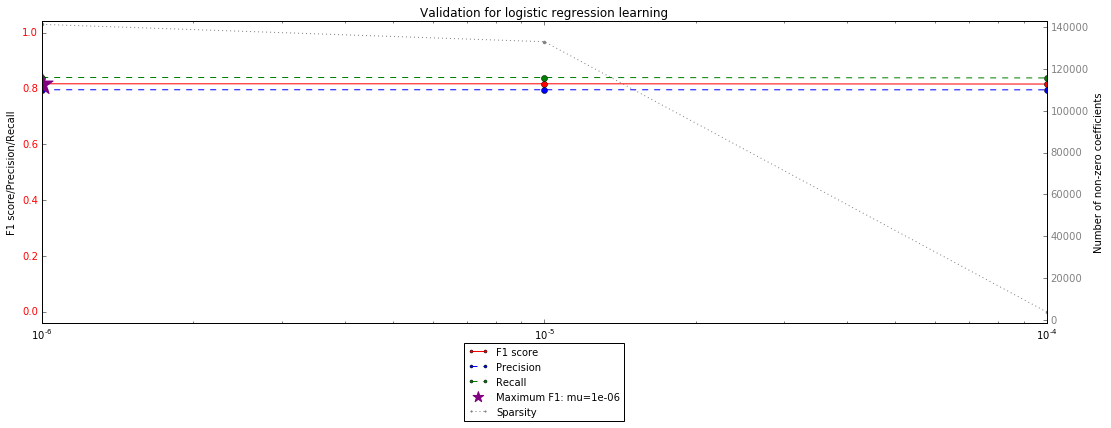

In [18]:
from snorkel.snorkel import Learner
from snorkel.learning import LogReg
from snorkel.learning_utils import GridSearch

learner = Learner(training_set, model=LogReg())

gs = GridSearch(learner, 'mu', [1e-6, 1e-5, 1e-4], candidate_set['development'], gold['development'])

Applying LFs...
Featurizing...


/System/Library/Frameworks/Python.framework/Versions/2.7/Extras/lib/python/numpy/core/_methods.py:55: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


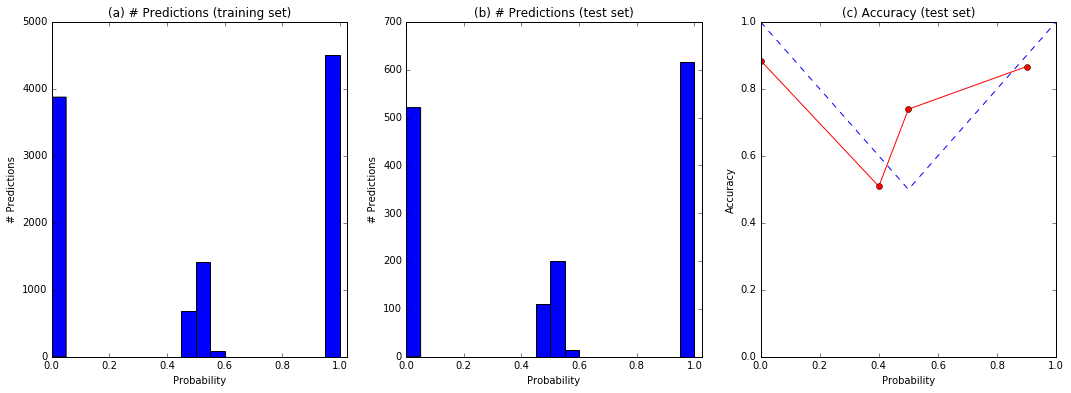

Test set size:	1462
----------------------------------------
Precision:	0.833935018051
Recall:		0.85873605948
F1 Score:	0.846153846154
----------------------------------------
TP: 693 | FP: 138 | TN: 517 | FN: 114


In [19]:
learner.test(candidate_set['testing'], gold['testing'])

## Corpus Measures

In [ ]:
from ddbiolib.utils import unescape_penn_treebank
from ddlite.ddlite_candidates import Ngrams,Ngram

def get_gold_labels(corpus, doc_ids=None):
    '''Generate gold labels for the provided corpus and document id set. 
    Note: requires an "annotations" attribute in corpus'''
    labels = []
    for doc in corpus:
        # filter to target document set
        if doc_ids and doc.doc_id not in doc_ids:
            continue
        sent_offsets = [s._asdict()["char_offsets"][0] for s in doc.sentences]
        for label in doc.attributes["annotations"]:
            sidx = -1
            for i in range(len(sent_offsets) - 1):
                if label.start >= sent_offsets[i] and label.end - 1 < sent_offsets[i+1]:
                    sidx = i
                    break
            if label.start >= sent_offsets[-1]:
                sidx = len(sent_offsets) - 1
            metadata = {"mention_type":label.mention_type}
            labels += [Ngram(label.start, label.end - 1, 
                             doc.sentences[sidx], metadata=metadata)]
            if sidx == -1:
                print>>sys.stderr,"WARNING sentence boundary error"
                print labels[-1]    
    return labels


def migrate_candidates(candidates, corpus):
    cands = []
    for c in candidates:
        words = unescape_penn_treebank(c.mention("words"))
        char_offsets = zip(c.mention("char_offsets"), map(len,words))
        char_offsets = map(lambda x:x[0]+x[1], char_offsets)
        char_start = min(c.mention("char_offsets"))
        char_end = max(char_offsets)
        sentence = corpus[c.doc_id].sentences[c.sent_id]
        cands += [Ngram(char_start, char_end - 1, sentence)]
    return cands

def metrics(cand_set, gold_set):
    """Return precision and recall relative to a "gold" set of candidates of the same type"""
    gold = gold_set if isinstance(gold_set, set) else set(gold_set)
    cs   = cand_set
    nc   = len(cs)
    ng   = len(gold)
    both = len(gold.intersection(cs))
    print "# of gold annotations\t= %s" % ng
    print "# of candidates\t\t= %s" % nc
    print "Candidate recall\t= %0.3f" % (both / float(ng),)
    print "Candidate precision\t= %0.3f" % (both / float(nc),)

In [ ]:
from ddbiolib.datasets.ncbi_legacy import NcbiDiseaseCorpus
from ddbiolib.parsers import CoreNlpParser,PickleSerializedParser 
#doc_ids = corpus.attributes["sets"]["testing"] if HOLDOUT_SET == "test" else corpus.attributes["sets"]["development"]
#prediction = model.get_predicted()

#gold_labels = get_gold_labels(corpus,doc_ids)

infile = "../data/corpora/ncbi/"
#cache_dir = "../data/corpora/ncbi/cache/"
cache_dir = "../ddbiolib/datasets/data/ncbi_disease_corpus/cache/"
parser = PickleSerializedParser(CoreNlpParser(),rootdir=cache_dir)

#cache = 
#parser = ""
corpus = NcbiDiseaseCorpus(infile, parser=parser)

prediction = model.get_predicted()
# proba = model.get_predicted_marginals()


In [ ]:
#snorkel_candidates = migrate_candidates(candidates,corpus)

In [ ]:
#tmp = [c for c in snorkel_candidates if c.id.split("-")[0] in doc_ids]
#print len(tmp)
#metrics(tmp,gold_labels)

In [ ]:
holdout_ids = corpus.cv["testing"].keys() if HOLDOUT_SET == "test" else corpus.cv["development"].keys()
scores = corpus.score(candidates, prediction, holdout_ids)

print "Precision: {:.3f}".format(scores["precision"])
print "Recall:    {:.3f}".format(scores["recall"])
print "F1-score:  {:.3f}".format(scores["f1"])

## Error Analysis

In [ ]:
class AnsiCodes:
    BLACK   = '\x1b[40m'
    RED     = '\x1b[41m'
    GREEN   = '\x1b[42m'
    YELLOW  = '\x1b[43m'
    BLUE    = '\x1b[44m'
    MAGENTA = '\x1b[45m'
    CYAN    = '\x1b[46m'
    WHITE   = '\x1b[47m'
   
    ENDC = '\033[0m'
    BOLD = '\033[1m'

def print_span(text, char_span, window=10,color=AnsiCodes.CYAN):
    pre = text[char_span[0]-window:char_span[0]]
    span = text[char_span[0]:char_span[1]]
    post = text[char_span[1]:char_span[1]+window]
    s = "{}{}{}{}{}{}".format(pre, AnsiCodes.BOLD, color, span, AnsiCodes.ENDC, post)
    print s

In [ ]:
prediction = [1] * len(prediction)
scores = corpus.score(candidates, prediction, holdout_ids )
print "Candidate Recall:  {:.3f}".format(scores["recall"])

In [ ]:
from ddbiolib.datasets import unescape_penn_treebank

prediction = model.get_predicted()

tp,fp,fn = corpus.classification_errors(candidates, prediction, holdout_ids)
print "TP: {} FP: {} FN: {}".format(len(tp),len(fp),len(fn))

#
# partial matches
#
c_index = corpus._candidate_index(candidates)
l_index = corpus._label_index(holdout_ids)
true_labels = set(corpus._ground_truth(holdout_ids))

print "--------------------------\nPartial False Positives\n--------------------------\n"
mapping = {}
for label in true_labels:
    doc_id,sent_id,idxs,char_span,_ = label
    span = (min(idxs),max(idxs)+1)
    text = l_index[doc_id][sent_id][span]
    mapping[label] = corpus.match(label, candidates, c_index)
    mentions = [" ".join(c.mention()) for c in mapping[label]]
    if len(mapping[label]) > 1 or (text not in mentions and len(mapping[label])!=0):
        for m in mentions:
            if m in text:
                char_offset = (text.index(m),text.index(m)+len(m))
                print_span(text,char_offset,1000,color=AnsiCodes.YELLOW)
            else:
                print text, "|", m
            
        print
        
partial = reduce(lambda x,y:x+y,mapping.values())
partial = map(lambda x:corpus.getkey(x),partial)
partial = dict.fromkeys(partial)

#
#
# complete false positives
#
print "--------------------------\nComplete False Positives\n--------------------------\n"
for cand in fp:
    # skip partial matches
    if cand in partial:
        continue
    
    doc_id,sent_id,idxs,char_offset,_ = cand
    span = (min(idxs),max(idxs)+1)
    idxs = list(idxs)
    i = [i for i,c in enumerate(candidates._candidates) if c.doc_id==doc_id and c.sent_id==sent_id and c.idxs==idxs ]
    pred = prediction[i[0]]
    c = candidates._candidates[i[0]]
    #mention = " ".join(unescape_penn_treebank(c.mention()))
    char_offset = (char_offset[0] - min(c.token_idxs), char_offset[1] - min(c.token_idxs))
    print_span(c.text,char_offset,20)